In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Exponential
from PySDM.physics.collision_kernels import Golovin, Geometric, ConstantK
from PySDM.physics.coalescence_efficiencies import Berry1967, ConstEc, Schlottke2010
from PySDM.physics.breakup_efficiencies import ConstEb
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS, ExponFrag, Gaussian
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

In [16]:
@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**3
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 1]
        #self.kernel = Golovin(b=1500 / si.second)
        self.kernel = ConstantK(a = 100.0 * si.cm**3 / si.second)
        self.coal_eff = ConstEc(Ec=0.0)
        self.fragmentation = Gaussian(mu=10 * si.micrometres, scale=5 * si.micrometres) #ExponFrag(scale=1e-6) #AlwaysN(n=1)
        self.break_eff = ConstEb(1.0) # no "bouncing"
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

[27.20436294] [99.998]
[1.86265107 3.17098034 3.96211879 2.53973094]
[26.56427364] [144.190627]


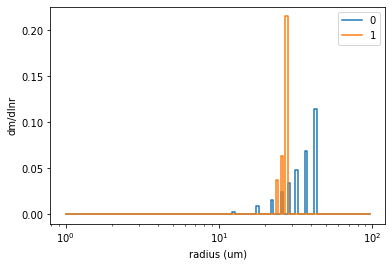

In [18]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(settings.kernel, settings.coal_eff, settings.break_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range)]
core = builder.build(attributes, products)

for step in settings.output_steps:
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get())
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend([0, 1, 2])